# EDA

In [163]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
import statistics
from visualisations import compare_histograms
import random
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer

from sklearn.linear_model import Ridge, RidgeCV, Lasso
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestRegressor

# set random seed for reproducibility
np.random.seed(42)

sns.set_theme(context='notebook', style='darkgrid', palette='Set3')

In [164]:
df = pd.read_csv('../data/clean_combined_wines.csv')
# set name column as index
df.set_index('name', inplace=True)
df.head()

,region,country,vintage,producer,wine_variety,grape_variety,price,rating,rating_qty,abv,reviewed_by,from_vivino
name,,,,,,,,,,,,
00 Wines Vgw Chardonnay 2017,Willamette Valley,United States,2017,00 Wines,white,Chardonnay,66.0,0.0,0,13.0,"JS, WE, WS",False
00 Wines Vgr Pinot Noir 2019,Willamette Valley,United States,2019,00 Wines,red,Pinot Noir,82.0,0.0,0,12.9,"WE, JS, RP",False
00 Wines Egw Chardonnay 2019,Willamette Valley,United States,2019,00 Wines,white,Chardonnay,95.0,0.0,0,NaN,"JS, RP, WE",False
100 Nails Ranch Pinot Noir 2019,Central Coast,United States,2019,100 Nails Ranch,red,Pinot Noir,14.0,0.0,0,14.2,WW,False
100 Nails Ranch Chardonnay 2019,Sonoma County,United States,2019,100 Nails Ranch,white,Chardonnay,14.0,0.0,0,14.2,0,False


In [165]:
df.shape

(50948, 12)

In [166]:
df.describe()

,price,rating,rating_qty,abv
count,50948.000000,50948.000000,50948.000000,9906.000000
mean,44.242284,3.103164,298.227821,13.605026
std,141.390631,1.594023,791.429115,1.462862
min,2.080000,0.000000,0.000000,1.200000
25%,10.160000,3.400000,22.000000,13.000000
50%,17.960000,3.800000,81.000000,13.500000
75%,37.540000,4.000000,268.000000,14.500000
max,8215.000000,5.000000,29389.000000,21.500000


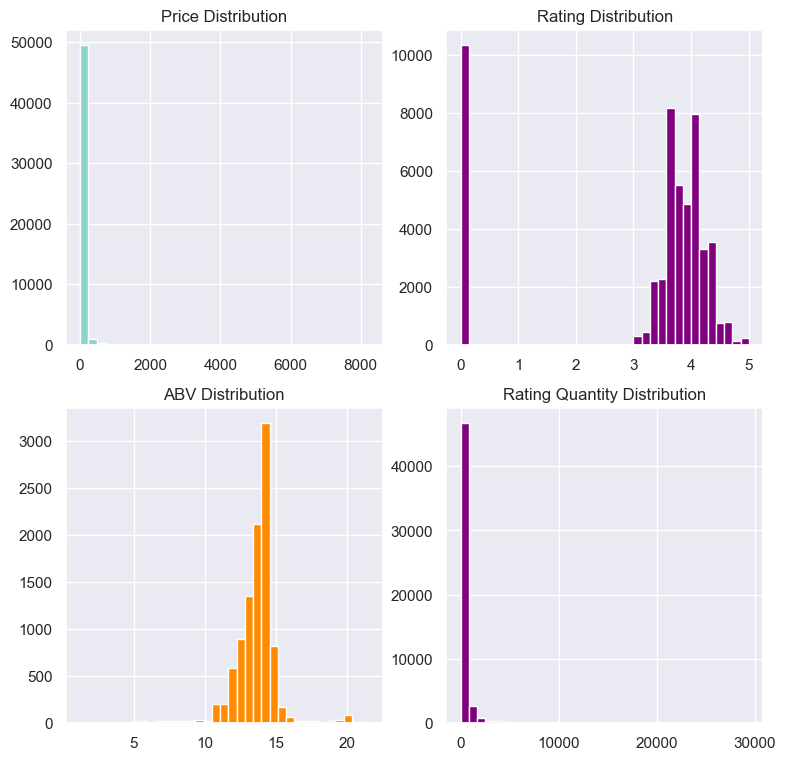

In [167]:
fig, axs = plt.subplots(2, 2, figsize=(9, 9))  # 4 subplots

# plot price
axs[0, 0].hist(df['price'], bins=35)
axs[0, 0].set_title('Price Distribution')
axs[0, 0].grid(True)

# plot rating
axs[0,1].hist(df['rating'], bins=35, color='Purple')
axs[0,1].set_title('Rating Distribution')  # Adjusted title and x label
axs[0,1].grid(True)

# plot rating_qty
axs[1, 1].hist(df['rating_qty'], bins=35, color='Purple')
axs[1, 1].set_title('Rating Quantity Distribution')  # Adjusted title and x label
axs[1, 1].grid(True)

# plot abv
axs[1, 0].hist(df['abv'], bins=35, color='DarkOrange')
axs[1, 0].set_title('ABV Distribution')  # Provided a title and x label
axs[1, 0].grid(True)

* Prices are heavily right skewed and would likely benefit from a logarithmic transformation before modelling.
* Rating qty also heavily right skewed and would likely benefit from a logarithmic transformation before modelling. Most wine have very few reviews, with some extreme outliers up to 29389. 
* ABV content fairly normally distibuted with clear spike at median of 13.5% 
- 

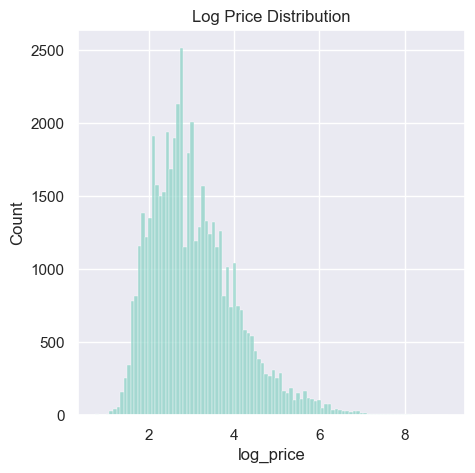

In [168]:
# remove price outliers from dataframe, log transform price and plot

df['log_price'] = np.log(df['price'])
plt.figure(figsize=(5, 5))
plt.title('Log Price Distribution')
sns.histplot(df['log_price'], bins=100)  # kde=False turns off the kernel density estimate plot overlay
plt.show();

* Log price much more normally distributed. 

Max outlier bound log_price: 5.586
Number of remaining rows: 49753, rows removed: 1195


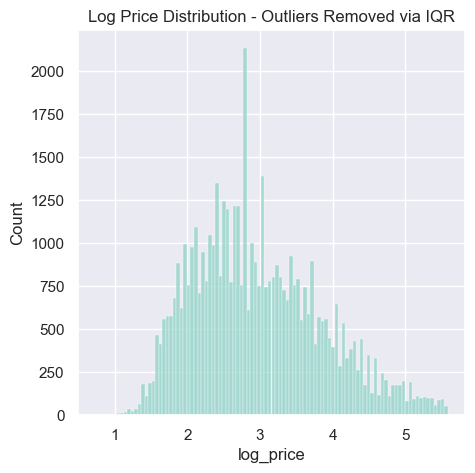

In [169]:
# calculate interquartile range of price, and set a limit at 1.5 IQR above 75% percentile
Qrt1 = np.quantile(df['log_price'], 0.25)
Qrt3 = np.quantile(df['log_price'], 0.75)
price_IQR = Qrt3 - Qrt1
outlier_price_limit = Qrt3 + (price_IQR * 1.5)
df_IQR_price = df[df['log_price'] < outlier_price_limit]
print('Max outlier bound log_price: ', round(outlier_price_limit,3), sep='')
print(f'Number of remaining rows: {df_IQR_price.shape[0]}, rows removed: {df.shape[0] - df_IQR_price.shape[0]}')
plt.figure(figsize=(5, 5))
plt.title('Log Price Distribution - Outliers Removed via IQR')
sns.histplot(df_IQR_price['log_price'], bins=100) 
plt.show();

In [170]:
df['log_price'].describe()

count    50948.000000
mean         3.051994
std          1.008018
min          0.732368
25%          2.318458
50%          2.888147
75%          3.625407
max          9.013717
Name: log_price, dtype: float64

### ABV - Alcohol Content

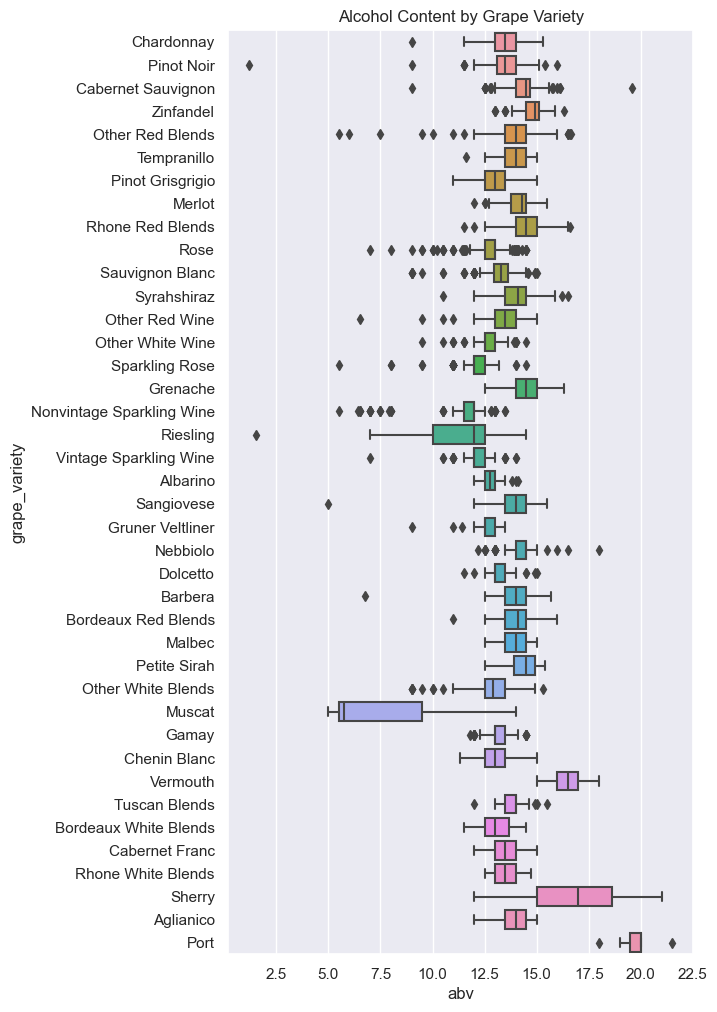

In [171]:
df_a = df[df['abv'].isna() == False]
popular_grape_varieties = df_a[(df_a['grape_variety'].isin((df_a['grape_variety'].value_counts().head(40).index)))]
plt.figure(figsize=(6, 12)) 
sns.boxplot(x='abv', y='grape_variety', data=popular_grape_varieties)
plt.xticks() 
plt.title('Alcohol Content by Grape Variety')
plt.show()


* Fair amount of variation between average abv and abv spread between differing grape varieties. Muscat and Riesling for example are trypically on the lower end of alcohol content.
* Vermouth, Port and sherry all being fortigied wines are the three highest in alcohol content. 

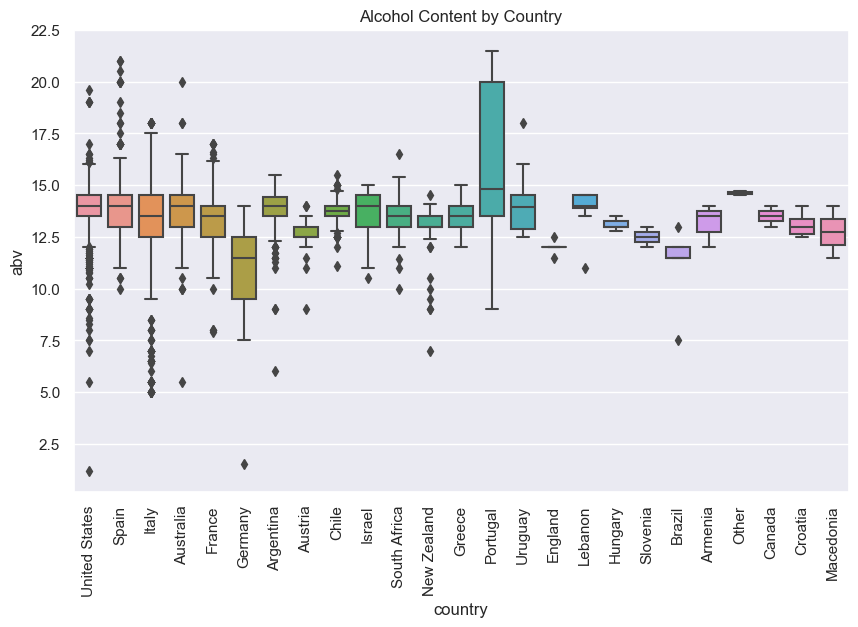

In [172]:
# Box plot for abv 
plt.figure(figsize=(10, 6)) 
sns.boxplot(x='country', y='abv', data=df_a)
plt.xticks(rotation=90) 
plt.title('Alcohol Content by Country')
plt.show()

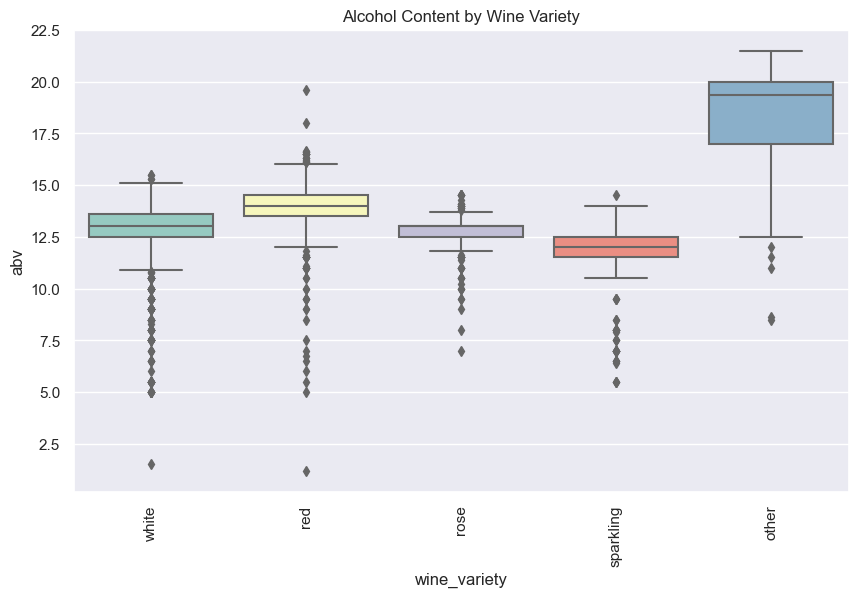

In [173]:

plt.figure(figsize=(10, 6)) 
sns.boxplot(x='wine_variety', y='abv', data=df_a)
plt.xticks(rotation=90) 
plt.title('Alcohol Content by Wine Variety')
plt.show()

# Correlations

In [174]:
df.columns

Index(['region', 'country', 'vintage', 'producer', 'wine_variety',
       'grape_variety', 'price', 'rating', 'rating_qty', 'abv', 'reviewed_by',
       'from_vivino', 'log_price'],
      dtype='object')

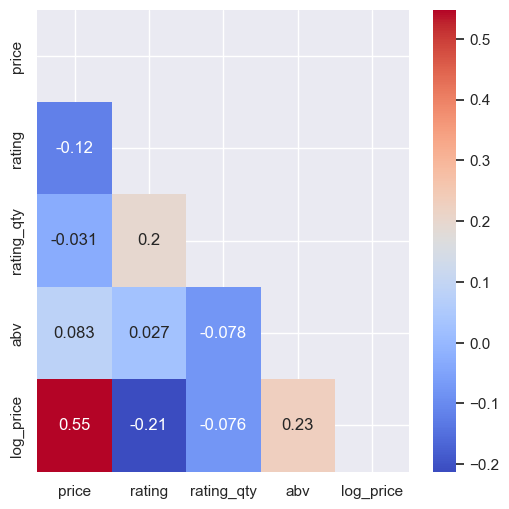

In [175]:
numeric = df.drop(columns = [ 'region', 'country', 'vintage', 'producer', 'wine_variety',
       'grape_variety','reviewed_by','from_vivino'])

plt.figure(figsize=(6, 6))

# Set up mask to be "True" in the upper triangle.
mask = np.zeros_like(numeric.corr())
mask[np.triu_indices_from(mask)] = True

sns.heatmap(numeric.corr(), mask = mask, annot=True, cmap='coolwarm');

# Price

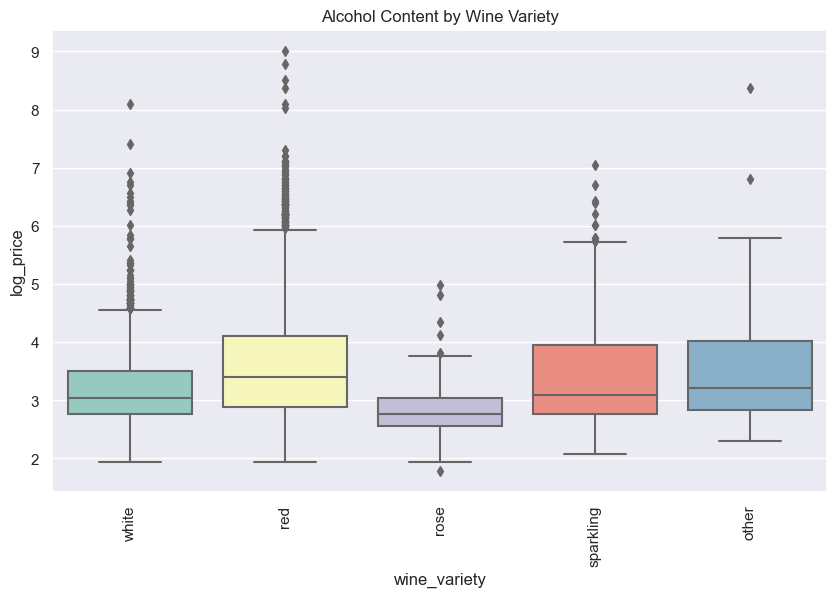

In [176]:
plt.figure(figsize=(10, 6)) 
sns.boxplot(x='wine_variety', y='log_price', data=df_a)
plt.xticks(rotation=90) 
plt.title('Alcohol Content by Wine Variety')
plt.show()

### Producers and Price

In [177]:
top_producers = df['producer'].value_counts().head(50).index

In [178]:
filtered_df = df[df['producer'].isin(top_producers)]
average_prices = filtered_df.groupby('producer')['price'].mean().reset_index()
to_plot = average_prices.sort_values(by='price', ascending=False)

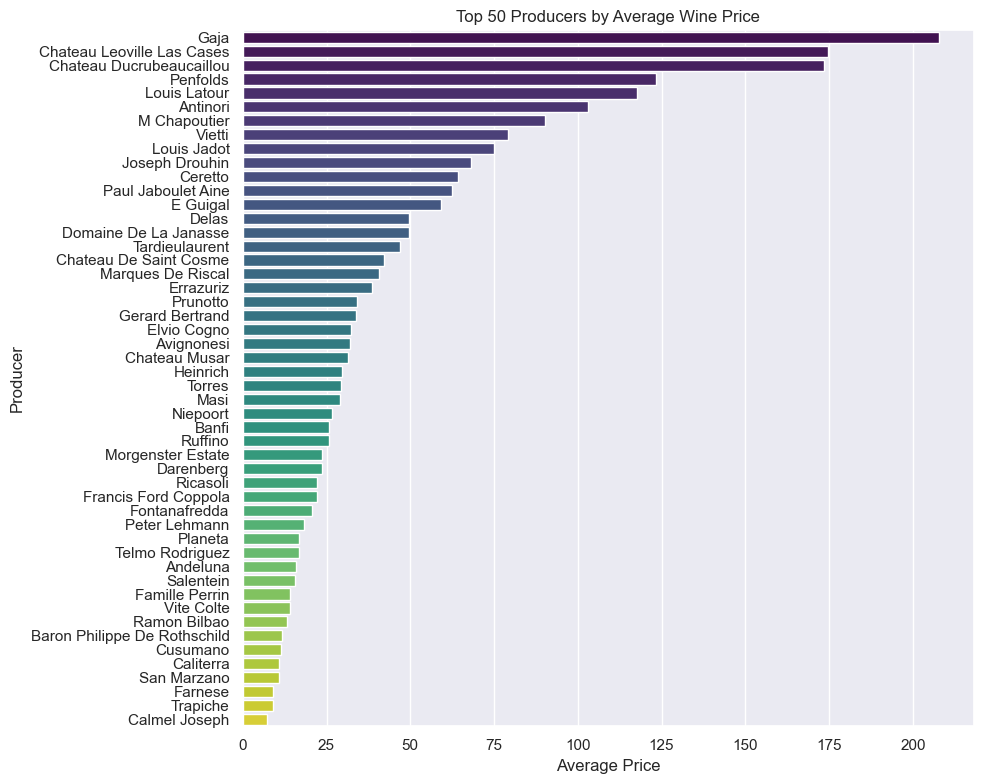

In [179]:
plt.figure(figsize=(10, 8))

# Create a horizontal bar plot
sns.barplot(x='price', y='producer', data=to_plot, palette='viridis')

# Add plot labels and title
plt.xlabel('Average Price')
plt.ylabel('Producer')
plt.title('Top 50 Producers by Average Wine Price')

# Show the plot
plt.tight_layout()
plt.show()

# Categoricals

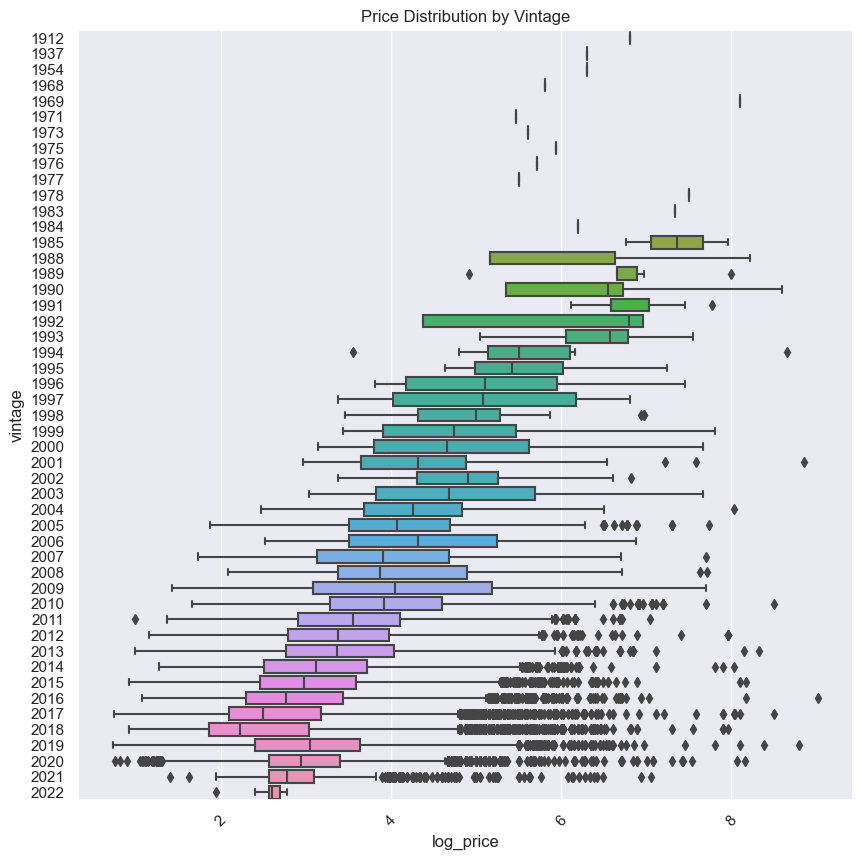

In [183]:
# Box plot for 'vintage' vs 'price'

df_sorted = df.sort_values(by='vintage')
df_sorted = df_sorted[df_sorted['vintage'] != 'unknown']
plt.figure(figsize=(10, 10))
sns.boxplot(x='log_price', y='vintage', data=df_sorted)
plt.xticks(rotation=45)
plt.title('Price Distribution by Vintage')
plt.show()

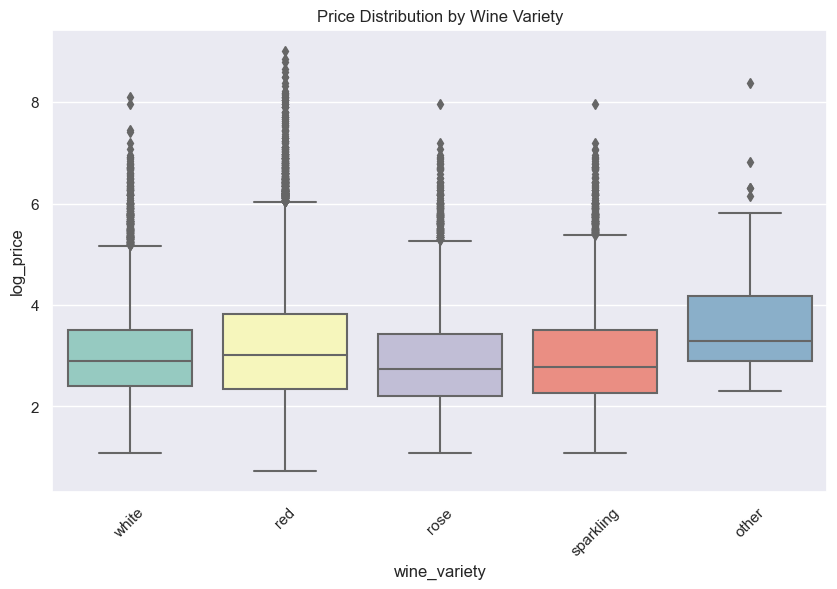

In [184]:
# Box plot for 'wine_variety' vs 'price'
plt.figure(figsize=(10, 6))
sns.boxplot(x='wine_variety', y='log_price', data=df)
plt.xticks(rotation=45) # Rotate x labels for better readability
plt.title('Price Distribution by Wine Variety')
plt.show()

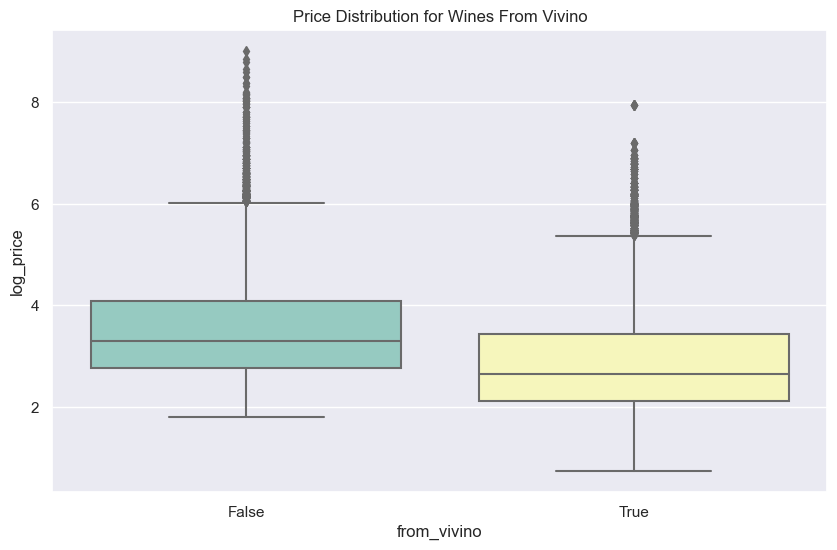

In [185]:
# Box plot for 'from_vivino' (bool) vs 'price'
plt.figure(figsize=(10, 6))
sns.boxplot(x='from_vivino', y='log_price', data=df)
# No need to rotate x labels here as 'from_vivino' is a boolean variable
plt.title('Price Distribution for Wines From Vivino')
plt.show()